In [15]:
"""
OBJETIVO : Definir y entrenar lso modelos. Ademas, recolectar los resultados para analizarlos mas adelante  
V2 : Se agrega redes pre entrenadas
"""
Autor='Diego Paredes'

In [16]:
#Manejo de Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox


#Machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

#Librerias estandar (Extras)
import re
import os
import time
import random
from datetime import datetime
import pickle

C:\Users\Shounen\anaconda3\envs\WB-PY39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 


C:\Users\Shounen\anaconda3\envs\WB-PY39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want 

In [17]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [18]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/'     

products = ['C13','C07','C08']
times   = ['10','20','30','40','50','00']


In [19]:
!python --version
print(tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Limitamos el GPU, en caso se necesite
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

Python 3.9.11
2.8.0
Num GPUs Available:  1


In [20]:
"""
Metodos para realizar el entrenamient - evaluacion del modelo
"""

'\nMetodos para realizar el entrenamient - evaluacion del modelo\n'

In [21]:
def getConv3D_func(p,run,input_1, shape=()):   
    
    x = input_1
    #if p['normLayer'][run]:
    #    x = tf.keras.layers.Rescaling(1./65536)(input_1)
        
    x = tf.keras.layers.Conv3D(32, (3,3,3), input_shape=(shape),padding='same', activation='relu')(x)    
    
    
    for iConv in range(p['cnn_cant'][run]):
        units = p['cnn_units'][run][iConv]
        maxPool = p['maxPool'][run][iConv]
        droupout = p['droupout'][run][iConv]        
        
        x = tf.keras.layers.Conv3D(units, (3,3,3), padding='same', activation='relu')(x)
        if maxPool:
            x = tf.keras.layers.MaxPooling3D()(x)
        if droupout:
            x = tf.keras.layers.Dropout(droupout)(x)
   
    
    output = tf.keras.layers.GlobalMaxPool3D()(x)
    
    return output 

In [22]:
def getConv2D_func(p,run,input_1, shape=()):   
    
    x = input_1
    #if p['normLayer'][run]:
    #    x = tf.keras.layers.Rescaling(1./65536)(input_1)
        
    x = tf.keras.layers.Conv2D(32, 3, input_shape=(shape),padding='same', activation='relu')(x)    
    
    
    for iConv in range(p['cnn_cant'][run]):
        units = p['cnn_units'][run][iConv]
        maxPool = p['maxPool'][run][iConv]
        droupout = p['droupout'][run][iConv]        
        
        x = tf.keras.layers.Conv2D(units, 3, padding='same', activation='relu')(x)
        if maxPool:
            x = tf.keras.layers.MaxPooling2D()(x)
        if droupout:
            x = tf.keras.layers.Dropout(droupout)(x)
   
    
    output = tf.keras.layers.GlobalMaxPool2D()(x)
    
    return output 

In [23]:
def getConv2D(p,run):    
    model = keras.Sequential()
    shape = (p['margen'][run],p['margen'][run],p['canales'][run])
        
    #if p['normLayer'][run]:
    #    model.add(tf.keras.layers.Rescaling(1./65536))    
        
    model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(p['margen'][run],p['margen'][run],p['canales'][run]),padding='same', activation='relu'))    
    
    for iConv in range(p['cnn_cant'][run]):
        units = p['cnn_units'][run][iConv]
        maxPool = p['maxPool'][run][iConv]
        droupout = p['droupout'][run][iConv]        
        
        model.add(tf.keras.layers.Conv2D(units, (3,3), padding='same', activation='relu'))
        if maxPool:
            model.add(tf.keras.layers.MaxPooling2D())
        if droupout:
            model.add(tf.keras.layers.Dropout(droupout))       
   
    
    model.add(tf.keras.layers.GlobalMaxPool2D())
    
    return model    

In [24]:
def getPreTrainedModel(p, run, shape=()):
    print('Se utilizara red pre entreanda : ',p['pre_trained'][run])
    convnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False , input_shape=shape)
    for capa in convnet.layers:
        capa.trainable = False
        
    
    return convnet

In [25]:
def crearModelo(p,run, redTipo):        

    shape = (p['tiempos'][run],p['margen'][run],p['margen'][run],p['canales'][run])    
    print(shape)
    if p['rnn_tipo'][run] == 'LSTM':
        input_1 = tf.keras.layers.Input(shape=shape)
        if p['pre_trained'][run]:
            convnet= getPreTrainedModel(p, run)
        else:
            convnet = getConv2D(p,run)
        timeD = tf.keras.layers.TimeDistributed(convnet)(input_1)
        timeD = layers.TimeDistributed(tf.keras.layers.Flatten())(timeD)
        _rnn =  tf.keras.layers.LSTM(p['rnn_units'][run])(timeD)
        listConcat = [_rnn]
    elif p['rnn_tipo'][run] == 'CONV3D':
        input_1 = tf.keras.layers.Input(shape=shape)
        convnet = getConv3D_func(p,run,input_1)    
        listConcat = [convnet]        
    elif p['rnn_tipo'][run] == 'CONV2D':
        input_1 = tf.keras.layers.Input(shape=shape[1:])
        if p['pre_trained'][run]:
            convnet= getPreTrainedModel(p, run, shape=shape[1:])
            convnet = tf.keras.layers.Flatten()(convnet.output)
        else:
            #convnet = getConv2D(p,run)
            convnet = getConv2D_func(p,run,input_1,shape=shape[1:])   
        listConcat = [convnet]   
    else:
        print(f"ERROR: No se especifico un tipo de red correcto... {p['rnn_tipo'] }")
        
    listInputs = [input_1]
    
    if len(p['inputs'][run])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][run][1:]:
            # The other input
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)

            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat) 
    
    
    
    dense_capas = [final]
    for iDense in range(p['dense_cant'][run]):
        units = p['dense_units'][run][iDense]
        if p['dense_tipo'][run] == 'RELU':
            dense_capas.append(tf.keras.layers.Dense(units=units, activation=tf.keras.activations.relu)(dense_capas[iDense]))
        if p['dense_tipo'][run] == 'SELU':
            dense_capas.append(tf.keras.layers.Dense(units=units, activation=tf.keras.activations.selu)(dense_capas[iDense]))
    
    # output
    if redTipo == 'Regresion':
        output = tf.keras.layers.Dense(units=1)(dense_capas[-1])      
    elif redTipo == 'Clasificacion':
        output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(dense_capas[-1])
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['redTipo']}")
        return -1      
    
    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])

    return full_model

In [26]:
def getMetrics(params, HP, run):
    redTipo = params['redTipo']
    paciencia = params['paciencia']
    
    lr = HP['lr'][run]    
    
    if redTipo == 'Clasificacion':    
        optimizer = keras.optimizers.Adam(learning_rate=lr)   
        if HP['loss'][run] == 'binary_crossentropy':
            loss_fn= keras.losses.BinaryCrossentropy()
        
        train_acc_metric = keras.metrics.BinaryCrossentropy()
        val_acc_metric = keras.metrics.BinaryCrossentropy()
        
        if paciencia:
            early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", patience=paciencia, mode="max")  
 
        
        metrics = ['acc', keras.metrics.TruePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.FalseNegatives()]
        

    elif redTipo == 'Regresion':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        loss_fn=keras.losses.MeanSquaredError()
        train_acc_metric = keras.metrics.MeanSquaredError()
        val_acc_metric = keras.metrics.MeanSquaredError()
        if paciencia:
            early_stopping = keras.callbacks.EarlyStopping(monitor="val_mse", patience=paciencia, mode="max")                                            
        metrics = ['mse']
        
        
    else:
        print('No se pudo crear las metricas')
        return -1    
         
        
    logs = Callback()
    callbacks = [logs]                     
    if paciencia:
        callbacks.append(early_stopping)
        
    metrics = {'optimizer': optimizer, 'loss_fn':loss_fn,'train_acc_metric': train_acc_metric,
               'val_acc_metric': val_acc_metric, 'metrics': metrics,'callbacks': callbacks}
    
    return metrics
        

In [27]:
def applyDA(img, DA):
    # DA = 0 , imagen original
    
    # DA = 1 , flip horizontal (FH)
    # DA = 2 , flip vertical (FV)
    # DA = 3 , Flip diagonal (FV + FH)
    # DA = 4 , Rotacion 90° (R90)
    # DA = 5 , Rotacion 270° (R270)
    # DA = 6 , FH + Rotacion 90° (FH + R90)
    # DA = 7 , FH + Rotacion 270° (FH + R270)    
    
    
    if DA == 1:
        img= tf.image.flip_left_right(img)  # FH
        return img
    elif DA == 2:
        return tf.image.flip_up_down(img)     # FV
        return img
    elif DA == 3:
        img = tf.image.flip_left_right(img)   # FH
        img= tf.image.flip_up_down(img)     # FV
        return img
    elif DA == 4:
        #img = tf.image.rot90(img, k=1)        # R90
        img = tfa.image.rotate(img, tf.constant(np.pi/2))        
        return img
    elif DA == 5:
        #img = tf.image.rot90(img, k=3)        # R270
        img = tfa.image.rotate(img, tf.constant(np.pi/2*3))
        return img
    elif DA == 6:
        img = tf.image.flip_left_right(img)   # FH
        #img = tf.image.rot90(img, k=1)        # R90
        img = tfa.image.rotate(img, tf.constant(np.pi/2))
        return img
    elif DA == 7:
        img = tf.image.flip_left_right(img)   # FH
        #img = tf.image.rot90(img, k=3)        # R270
        img = tfa.image.rotate(img, tf.constant(np.pi/2*3))  
        return img
    else:
        return img

In [28]:
def get_sat_time_steps(n):    
    if n==2:
        return [5,0]
    if n==3:
        return [5,3,0]
    if n==4:
        return [5,3,2,0]
    if n==5:
        return [5,3,2,1,0]
    if n==6:
        return [5,4,3,2,1,0]
    
    return [5]

In [29]:
#Transformamos un filename tensor en una imagen
def read_png_file(item, value,p, run, path_base, DA=0, _3D=False, redTipo='Clasificacion'):
    # imagenData[0] = XO
    # imagenData[1] = XA
    # imagenData[2] = Fecha
    imagenData = tf.strings.split(item['imagen'], sep='--')
    
    
    size = int(p['margen'][run] / 2)
    timeJoin = []
    for j in get_sat_time_steps(p['tiempos'][run]):
        filename = path_base + 'PNG/' + imagenData[2] + '/' + imagenData[2] + '_' + str(j) + '.png'        
        image_string = tf.io.read_file(filename)
        img_decoded = tf.io.decode_png(image_string, dtype=tf.uint16, channels=3)       
        
        
        if p['normLayer'][run]:            
            img_decoded = tf.cast(img_decoded, dtype=tf.float32) / tf.constant(65535, dtype=tf.float32)
        
        if DA:
            img_decoded = applyDA(img_decoded, item['DA'])
                
        timeJoin.insert(0,img_decoded[int(imagenData[1]) - size:int(imagenData[1]) + size,
                                      int(imagenData[0]) - size:int(imagenData[0]) + size,
                                      0:p['canales'][run]])
 
        
    if p['tiempos'][run]==1:
        imagenData = tf.reshape(timeJoin[0],(p['margen'][run],p['margen'][run],p['canales'][run]))
    else:
        if _3D:        
            img = tf.reduce_mean( timeJoin , axis=0 )
            imagenData = tf.reshape(img,(p['margen'][run],p['margen'][run],p['canales'][run]))
        else:
            img = tf.stack(timeJoin, axis=0)
            imagenData = tf.reshape(img,(p['tiempos'][run],p['margen'][run],p['margen'][run],p['canales'][run]))
        
    
    
    if len(p['inputs'][run]) == 1:
        return imagenData, int(value)
    
    item['imagen'] = imagenData
    itemL = []
    for inpL in p['inputs'][run]:
        itemL.append(item[inpL])
    
    if redTipo=='Regresion':
        return tuple(itemL), float(value)
    else:     
        return tuple(itemL), int(value)


In [30]:
def splitDataset(p,HP,run, path_imagenes):
    
    test = pd.read_csv(p['dsVal'])
    train = pd.read_csv(p['dsTrain'])
    
    if p['dataset']:
        print('Se escojera una parte del Dataset')
        train =  train.sample(frac=p['dataset'])
        test = test.sample(frac=p['dataset'])
    
               
    inputsList = {}
    inputsListTest = {}
    
    # Agregamos un atributo para indicar que el dato va realizar DA
    if p['DA']:        
        inputsList['DA'] = train['DA'].tolist() 
        
    print(f'Tamaño del dataset: Train {len(train)}  - Val {len(test)}') 
    
    for inp in HP['inputs'][run]:
        inputsList[inp] = train[inp].tolist()  
        inputsListTest[inp] = test[inp].tolist()  
    
    
    train_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[HP['outputs'][run]].tolist()))           
    val_dataset = tf.data.Dataset.from_tensor_slices(((inputsListTest),test[HP['outputs'][run]].tolist()))     
    
    train_dataset = train_dataset.map(lambda x ,y : read_png_file(x,y,HP,run,path_imagenes,p['DA'],p['meanMatrizImagen'],p['redTipo']))
    val_dataset = val_dataset.map(lambda x ,y : read_png_file(x,y,HP,run,path_imagenes,False,p['meanMatrizImagen'],p['redTipo']))
       
    
    train_dataset = train_dataset.batch(p['batch'])
    val_dataset = val_dataset.batch(p['batch'])
    
    
    return train_dataset, val_dataset

In [31]:
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT
        pass
    except:
        print(f"No se pudo crear el directorio: {newDir}")
        pritn(f'Path base: {path}')
        pritn(f'Nuevo    : {newDir}')        
        return None

In [32]:
def iniciarProyect(path_base, params, HP):
    repDir = crearDir(f'{path_base}/Archivos/Resultados', params["redTipo"])   
    repDir = crearDir(repDir, params["directory"])
    repDir = crearDir(repDir, params["Proyect"])
    
    excelFile = f'{repDir}/Stats-{params["Proyect"]}.xlsx'
    
    if params['record'] and not os.path.exists(excelFile):
        writer = pd.ExcelWriter(excelFile, engine = 'xlsxwriter')
        #joinParams = params | HP
        keys_values = params.items()
        strParams = {str(key): str(value) for key, value in keys_values}        
        
        pd.DataFrame(strParams,index=[0]).to_excel(writer, sheet_name = 'Informacion')
        
        pd.DataFrame(HP).to_excel(writer, sheet_name = 'Informacion',startrow=3)
        
        writer.save()     
    return repDir , excelFile

In [33]:
def getCM(logs):
    lKeys = list(logs.keys())
    
    try:
        TN = int(logs[[x for x in lKeys if 'val_true_negatives' in x][0]])
        TP = int(logs[[x for x in lKeys if 'val_true_positives' in x][0]])
        FN = int(logs[[x for x in lKeys if 'val_false_negatives' in x][0]])
        FP = int(logs[[x for x in lKeys if 'val_false_positives' in x][0]])
    except:
        print(f'\nNo se pudo leer keys para la matriz de confucion en logs : {lKeys}')
        print(f'Se intento leer: val_true_negatives,val_true_positives, val_false_negatives y val_false_positives')
    
       
    y_true =  [0]*TN + [1]*TP + [1]*FN + [0]*FP
    _y_pred = [0]*TN + [1]*TP + [0]*FN + [1]*FP
    
    return TN, FP, FN, TP, np.array(y_true), np.array(_y_pred)

In [34]:
class CustomCB(Callback):
    """ Custom callback to compute metrics at the end of each training epoch"""
    def __init__(self, val_ds=None, WANDB=True):     
        self.val_ds = val_ds  
        self.history = {}
        self.wandb = WANDB
   
   
    def on_epoch_end(self, epoch, logs={}):  
        TN, FP, FN, TP, y_true, _y_pred = getCM(logs)
        
        self.history.setdefault('epoch', []).append(epoch)
        
        self.history.setdefault('loss', []).append(logs['loss']) 
        self.history.setdefault('acc', []).append(logs['acc'])  
        self.history.setdefault('val_loss', []).append(logs['val_loss']) 
        self.history.setdefault('val_acc', []).append(logs['val_acc']) 
        
        
        self.history.setdefault('val_TN', []).append(TN) 
        self.history.setdefault('val_FP', []).append(FP)
        self.history.setdefault('val_FN', []).append(FN) 
        self.history.setdefault('val_TP', []).append(TP) 
        
            
        if self.wandb:
            wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                                    preds=_y_pred, y_true=y_true,
                                    class_names=[0,1]),                   
                       'val_TN' :TN,'val_FN' :FN,'val_TP' :TP,'val_FP' :FP,
                       'val_acc': logs['val_acc'],'loss' : logs['loss'],
                       'val_loss': logs['val_loss'],'acc' : logs['acc']                  
                      })


In [35]:
def crearCallbacks(statsDir, HP,run, metricas, p):
    CB = metricas['callbacks']
    
    idModel = datetime.today().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = statsDir + '/Model_{epoch:02d}_' + f'{HP["rnn_tipo"][run]}_{HP["outputs"][run]}_{idModel}.hdf5' 
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1)
    
    # Iniciamos WANDB
    if p['record']:        
        CB.append(cp_callback)   
     
    if p['WANDB']:
        config = dict(learning_rate=HP['lr'][run], epochs = p['epocas'],
             batch_size = p['batch'],architecture="CNN", 
             num_classes = 2,)
        wandb.init(project=f'{p["Proyect"]}',            
                   config=config,
                   name= f'Ex_({HP["canales"][run]}-{HP["tiempos"][run]}-{HP["margen"][run]})_{idModel}')   
                                               
    return CB, idModel

In [56]:
def trainModel(path_base,path_imagenes,params,HP, criterio):        
    """ Creamos los directorios para los reportes  """             
    repDir, statsFile  = iniciarProyect(path_base, params, HP)
    print(f'DIRECTORIO BASE : {repDir}')
    
    
    """ Comenzamos el entrenamiento """ 
    # Una iteracion por cada Hiperparametro (HP) que existe
    ds_i = 0  
    resultados = [] 
    for run in range(HP['runs']):
        ds_i += 1                 
        print(f'Inicio de la prueba N°: {(run+1)}/{HP["runs"]}')         
        print(f'- Nombre del Proyecto : {params["Proyect"]}')
        print(f'- Batch size          : {params["batch"]}')
        print(f'- Criterio {criterio} : {HP[criterio][run]}')
        print('__________________________________________________')        
        

        
        """ GUARDAMOS REPORTES """                
  
        idModel = '20230710_040131'
        try:
            #resultados.append(history.history)
            P_FILE  = f"C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Resultados/Clasificacion/RNN-V2/{params['Proyect']}/"
            P_NAME =  P_FILE + f'Test-1-{idModel}.csv'

            with open(P_NAME, 'rb') as file_pi:
                res = pickle.load(file_pi)
            # Guardamos las estadisticas
            if params['record']:                
                with pd.ExcelWriter(statsFile, mode="a", engine="openpyxl", if_sheet_exists='overlay') as writer:                    
                    tempDF = pd.DataFrame(res)
                    if params['redTipo'] == 'Clasificacion':
                        tempDF.columns = ['loss', 'acc', 'TP', 'TN', 'FP','FN',
                                          'val_loss','val_acc','val_TP','val_TN','val_FP','val_FN']
                    tempDF.to_excel(writer,startrow=0,
                                    sheet_name=f'{run}-{idModel}')
            if params['WANDB']:
                wandb.finish()            
        except Exception as e:
            print(f'ERROR: No se pudo guardar los resulatdos test: {run}', str(e))
            try:
                pass
                #with open(f'{repDir}/Test-{run}-{idModel}.csv', 'wb') as file_pi:
                #    pickle.dump(history.history, file_pi)
            except Exception:
                print(traceback.format_exc())
                print(f'ERROR: No se pudo guardar el hist temporal')
                return history
            
        
    return resultados

In [61]:
"""
 Definimos las varibles para las iteraciones
"""

modelTipo = 'Clasificacion'
rnnTipo = 'LSTM' #'LSTM' CONV3D
idProject = '20230709_19' #datetime.today().strftime("%Y%m%d_%H")

p_train = {
            # Variables generales
          'products': products,
          'times'   : times,
    
            # Reportes
          'directory': 'RNN-v2', # 'RNN'
          'Proyect'  : f'{modelTipo}-{idProject}', # TesisDiego
          'record'   : True,  # Grabar los resultados en  excels    
          'WANDB'    : False, # Grabar los resultados en WANDB
    
            # Datos del modelo
          'redTipo'  : modelTipo, # Clasificacion / Regresion
          'rnn'      : True,  # Redes recurrentes          
          'meanMatrizImagen' : False, # !!! RNN modelos SIEMPRE EN FALSE  !!!
          
        
            # Variables del entrenamiento                
          'batch'    : 32,     
          'epocas'   : 100,  
          'paciencia': 0,   # 0 = No paciencia  (val_accuracy)
    
    
           # Dataset
          'dsTrain'  : f'{path_base}/Archivos/Dataset/{modelTipo}/Entrenamiento/V9_SplitCon_DA4/CLASE_TrainDS_1.csv',  
          'dsVal'    : f'{path_base}/Archivos/Dataset/{modelTipo}/Validacion/ClaseV9_ValidacionDS.csv',
          'dataset'  : None,     # 1 = 100% del ds
          'DA'       : True,  # Usaulmente para clasificacion          
         }

cantRuns = 1

 # Hiper parametros     
hiperparams = {    
               # General
              'dsTName'     :['XXXXX_V2']*cantRuns,                         
              'inputs'     : [['imagen', 'dato','umb1','altura']]*cantRuns,
              'outputs'    : ['clase']*cantRuns,
    
              # Modelo
              'lr'         : [0.001]*cantRuns, 
              'loss'       : ['binary_crossentropy']*cantRuns,
              'normLayer'  : [True]*cantRuns, 
              'pre_trained': [[]]*cantRuns, #'ResNet50'
    
               # Capas convulucionales
              'cnn_cant'   : [2]*cantRuns,
              'cnn_units'  : [[32,64]]*cantRuns,
              'droupout'   : [[0.2,0.3]]*cantRuns,
              'maxPool'    : [[False,False]]*cantRuns,              
    
               # Capas Recurrentes
              'rnn_tipo'   : [rnnTipo]*cantRuns,
              'rnn_units'  : [64]*cantRuns,    
              
              # Capas densas
              'dense_tipo' : ['RELU']*cantRuns, #RELU
              'dense_cant' : [2]*cantRuns,
              'dense_units': [[128,64]]*cantRuns,
              
              # Imagenes satelitates
              'canales'    : [3]*cantRuns,
              'tiempos'    : [6]*cantRuns,#6
              'margen'     : [10]*cantRuns, 
    
              # -
              'runs'       : cantRuns
              }


# Forma del DS
if p_train['dsVal']:
    dfVal = pd.read_csv(p_train['dsVal'])
    print(f'VALDIACION : {len(dfVal)}')
    print('--------------------------------------------------')
    
tempDF = pd.read_csv(p_train['dsTrain'])
print(f'TRAIN: {len(tempDF)}')
tempDF.head(2)

VALDIACION : 2634
--------------------------------------------------
TRAIN: 4880


,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,...,umb2,fecha,flag,flagV2,imagen,clase,index_st_group,flag_m2_group,DA,stratify
0,0,114,38945,48774,PICHARI,47E880E2,539,772,-73.83952,-12.52219,...,24.0,2021-12-31-07,C0000002,D02,539--772--2021-12-31-07,1,47E880E2-25,0,0,0
1,1,17,10869,39135,ALAMOR,47E0D438,175,325,-80.39788,-4.48047,...,10.2,2021-03-01-06,C0000002,D02,175--325--2021-03-01-06,1,47E0D438-9,0,0,1


In [62]:
%%time
resultado = trainModel(path_base,path_imagenes,p_train,hiperparams, 'tiempos')

DIRECTORIO BASE : C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Resultados\Clasificacion\RNN-v2\Clasificacion-20230709_19
Inicio de la prueba N°: 1/1
- Nombre del Proyecto : Clasificacion-20230709_19
- Batch size          : 32
- Criterio tiempos : 6
__________________________________________________
CPU times: total: 46.9 ms
Wall time: 88.2 ms


In [39]:
file1 =  'Test-0-20230709_191136.csv'
file2 =  'Test-1-20230710_040131.csv'
path = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Resultados/Clasificacion/RNN-V2/Clasificacion-20230709_19/'

<AxesSubplot:>

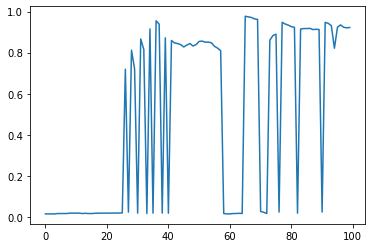

In [44]:
import pandas as pd
import pickle
import plotly.express as px
with open(path+file2, 'rb') as file_pi:
    df = pd.DataFrame(pickle.load(file_pi))
df['val_acc'].plot()

<AxesSubplot:>

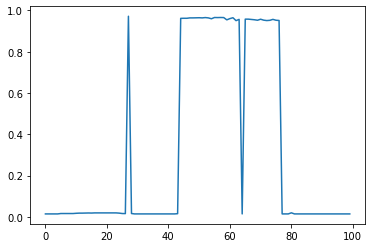